# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [22]:
# Use this space for any additional import statements you need
import collections
import nltk

In [3]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.UNICODE_EMOJI : 
    for em in emoji.UNICODE_EMOJI[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    
    """

    # Fill in the correct values here. 
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens/num_tokens
    num_characters = len("".join(tokens))
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        
    return([num_tokens, num_unique_tokens,
            num_characters,
            lexical_diversity
            ])
    

def is_emoji(s):
    return(s in all_language_emojis)

def contains_emoji(s):
    s = str(s)
    emojis = [ch for ch in s if is_emoji(ch)]
    return(len(emojis) > 0)


def remove_stop(tokens):
    stopwords = set(nltk.corpus.stopwords.words('english'))
    return [t for t in tokens if t.lower() not in stopwords]
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    collapse_whitespace = re.compile(r'\s+')
    return([item.lower() for item in collapse_whitespace.split(text)])

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [6]:
# Feel fre to use the below cells as an example or read in the data in a way you prefer

data_location = "./M1 Results/"
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}

# Section Complete

In [7]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [8]:
twitter_data.head()

,screen_name,name,id,location,followers_count,friends_count,description,artist
0,hsmcnp,Country Girl,35152213,NaN,1302,1014,NaN,cher
1,horrormomy,Jeny,742153090850164742,Earth,81,514,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,cher
2,anju79990584,anju,1496463006451974150,NaN,13,140,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,cher
3,gallionjenna,J,3366479914,NaN,752,556,csu,cher
4,bcscomm,bcscomm,83915043,"Washington, DC",888,2891,Writer @Washinformer @SpelmanCollege alumna #D...,cher


In [11]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [13]:
twitter_data.head()

,screen_name,name,id,location,followers_count,friends_count,description,artist
0,hsmcnp,Country Girl,35152213,NaN,1302,1014,NaN,cher
1,horrormomy,Jeny,742153090850164742,Earth,81,514,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,cher
2,anju79990584,anju,1496463006451974150,NaN,13,140,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,cher
3,gallionjenna,J,3366479914,NaN,752,556,csu,cher
4,bcscomm,bcscomm,83915043,"Washington, DC",888,2891,Writer @Washinformer @SpelmanCollege alumna #D...,cher


In [14]:
# read in the lyrics here

root_path = lyrics_folder
lyric_data = dict()
for dir_name in os.listdir(data_location+root_path):
  if dir_name not in  [".DS_Store",".ipynb_checkpoints"]:
      file_path = root_path+'/'+dir_name
      lyric_data[dir_name] = dict()
      for file_name in os.listdir(data_location+file_path):
        if file_name not in  [".DS_Store",".ipynb_checkpoints"]:
            full_file_path = file_path+'/'+file_name
            with open(data_location+full_file_path, 'r') as f:
                text = f.read()
                title = text.split("\n")[0].strip('"')
                artist = dir_name
                lyric_data[artist][title] = text
      print(f"Read lyrics: {len(lyric_data[artist].keys())} songs of {dir_name}")

Read lyrics: 313 songs of cher
Read lyrics: 93 songs of robyn


In [15]:
lyrics_data = (pd.DataFrame(lyric_data)
            .reset_index()
            .rename(columns = {'index':'title'}))
lyrics_data.loc[lyrics_data['robyn'].isnull()==False,'artist'] = 'robyn'
lyrics_data.loc[lyrics_data['cher'].isnull()==False,'artist'] = 'cher'
lyrics_data.loc[lyrics_data['robyn'].isnull()==False,'lyric'] = lyrics_data['robyn']
lyrics_data.loc[lyrics_data['cher'].isnull()==False,'lyric'] = lyrics_data['cher']
lyrics_data.drop(['cher','robyn'],axis = 1, inplace=True)
lyrics_data.head()

# Section Complete

,title,artist,lyric
0,88 Degrees,cher,"""88 Degrees""\n\n\n\nStuck in L.A., ain't got n..."
1,A Different Kind Of Love Song,cher,"""A Different Kind Of Love Song""\n\n\n\nWhat if..."
2,After All,cher,"""After All""\n\n\n\nWell, here we are again\nI ..."
3,Again,cher,"""Again""\n\n\n\nAgain evening finds me at your ..."
4,Alfie,cher,"""Alfie""\n\n\n\nWhat's it all about, Alfie?\nIs..."


## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove punctuation
* Split on whitespace
* Remove stopwords (optional)

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove punctuation other than emojis or hashtags
* Split on whitespace
* Remove stopwords

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [23]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop,]

lyrics_data["tokens"] = lyrics_data["lyric"].apply(prepare,pipeline=my_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len) 

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 

# Section Complete

In [24]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [25]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
1270236,cher,"“I would have lost heart, unless I had believe...","[“i, would, lost, heart, unless, believed, wou..."
988007,cher,Im a free spirited guy who craves on achieving...,"[im, free, spirited, guy, craves, achieving, h..."
2171249,cher,#LLWEBA💙 #LLJD🤞🏽 #LLBUBBA🦍 Forever QuanCrazy💙,"[#llweba💙, #lljd🤞🏽, #llbubba🦍, forever, quancr..."
2620203,cher,Travel writer @NYTimestravel. Author @VikingBo...,"[travel, writer, nytimestravel, author, viking..."
364709,cher,Mother to three beautiful humans and a wife to...,"[mother, three, beautiful, humans, wife, prett..."
3920425,cher,"I'm a Brooklynite, animal lover, chocoholic! E...","[im, brooklynite, animal, lover, chocoholic, e..."
2569098,cher,TWIN CITIES. @youthprise | run mentor w/ @mile...,"[twin, cities, youthprise, run, mentor, w, mil..."
932068,cher,🦇,[🦇]
716177,cher,My real account WA: 081519820422 love you Tayl...,"[real, account, wa, 081519820422, love, taylor..."
3421021,cher,Singer/Songwriter 🌹Santa Barbara🌹Instagram: @b...,"[singersongwriter, 🌹santa, barbara🌹instagram, ..."


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: I think there could be a copule areas of improvement, one that would be interesting would be to interpret the emokis into the words they take the place for and then perform our analysis. 

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [26]:
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    
    """

    # Fill in the correct values here. 
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens/num_tokens
    num_characters = len("".join(tokens))
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        
    return([num_tokens, num_unique_tokens,
            num_characters,
            lexical_diversity
            ])

# Section Complete

In [27]:
text = [token for tokens in lyrics_data[lyrics_data['artist']=="robyn"]['tokens'].tolist() for token in tokens if token]
print("Lyrics by Artist: robyn")
descriptive_stats(text, verbose=True)

Lyrics by Artist: robyn
There are 13186 tokens in the data.
There are 2156 unique tokens in the data.
There are 63767 characters in the data.
The lexical diversity is 0.164 in the data.


[13186, 2156, 63767, 0.16350674958289094]

In [28]:
# calls to descriptive_stats here

text = [token for tokens in lyrics_data[lyrics_data['artist']=="cher"]['tokens'].tolist() for token in tokens if token]
print("Lyrics by Artist: cher")
descriptive_stats(text, verbose=True)

Lyrics by Artist: cher
There are 35580 tokens in the data.
There are 3701 unique tokens in the data.
There are 171009 characters in the data.
The lexical diversity is 0.104 in the data.


[35580, 3701, 171009, 0.10401911186059584]

Q: what observations do you make about these data? 

A: The first obersvation I see is the lexical diversity bewteen the two artists. This was something I believe we were asked about in the previous assignment. In this case the Cher data's lexical diversity is slightly lower than Robyn. Seeing that Cher has more music it is also understandable that there are far more tokens in her dataset.


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents, if we view each data source as a single document, or too many, if we view each description as a separate document. In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To get around this, we find tokens for each corpus that match the following criteria:

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.


In [29]:
lyrics_data.head()

,title,artist,lyric,tokens,num_tokens
0,88 Degrees,cher,"""88 Degrees""\n\n\n\nStuck in L.A., ain't got n...","[88, degrees, stuck, la, aint, got, friends, h...",183
1,A Different Kind Of Love Song,cher,"""A Different Kind Of Love Song""\n\n\n\nWhat if...","[different, kind, love, song, world, crazy, sa...",138
2,After All,cher,"""After All""\n\n\n\nWell, here we are again\nI ...","[well, guess, must, fate, weve, tried, deep, i...",121
3,Again,cher,"""Again""\n\n\n\nAgain evening finds me at your ...","[evening, finds, door, ask, could, try, dont, ...",35
4,Alfie,cher,"""Alfie""\n\n\n\nWhat's it all about, Alfie?\nIs...","[alfie, whats, alfie, moment, live, whats, sor...",68


In [30]:
# your code here
# The token appears at least n times in all corpora
# The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

def unique_token(input_df,cutoff=5):
  all_tokens = [token for tokens in input_df['tokens'].tolist() for token in tokens if token]
  # corpora frequency
  all_counter=collections.Counter(all_tokens)
  # The token appears at least n times in all corpora
  freq_cutoff_tokens = {k:v for k,v in all_counter.items() if v >= cutoff}
  unique_tokens = []
  for id in range(input_df.shape[0]):
    current_tokens = [token for token in input_df['tokens'][id] if token]
    current_counter=collections.Counter(current_tokens)
    # The tokens of top 10 highest ratio
    other_tokens = [token for tokens in input_df['tokens'].drop(id).tolist() for token in tokens if token]
    other_counter = collections.Counter(other_tokens)
    # calculate ratio
    ratio_tokens = {k:v/other_counter[k] for k,v in current_counter.items() if k in other_counter.keys()}
    sorted_ratio = dict(sorted(ratio_tokens.items(), key = lambda kv: kv[1]))
    top_10_ratio = {k: sorted_ratio[k] for k in list(sorted_ratio)[:10]}
    # intersect and append
    unique_tokens.append([t for t in top_10_ratio.keys() if t in freq_cutoff_tokens.keys()])
    
  input_df['unique_tokens'] = unique_tokens
  return input_df


In [31]:
# Using the suggested cutoff of n = 5

unique_token(lyrics_data,cutoff=5).head()

,title,artist,lyric,tokens,num_tokens,unique_tokens
0,88 Degrees,cher,"""88 Degrees""\n\n\n\nStuck in L.A., ain't got n...","[88, degrees, stuck, la, aint, got, friends, h...",183,"[love, go, one, cant, take, get, got, like, co..."
1,A Different Kind Of Love Song,cher,"""A Different Kind Of Love Song""\n\n\n\nWhat if...","[different, kind, love, song, world, crazy, sa...",138,"[im, cant, could, go, believe, would, world, a..."
2,After All,cher,"""After All""\n\n\n\nWell, here we are again\nI ...","[well, guess, must, fate, weve, tried, deep, i...",121,"[love, know, never, take, way, right, still, w..."
3,Again,cher,"""Again""\n\n\n\nAgain evening finds me at your ...","[evening, finds, door, ask, could, try, dont, ...",35,"[love, know, take, say, way, back, ill, dont, ..."
4,Alfie,cher,"""Alfie""\n\n\n\nWhat's it all about, Alfie?\nIs...","[alfie, whats, alfie, moment, live, whats, sor...",68,"[know, youre, heart, take, love, way, let, day..."


In [34]:
# Comparing the results when the cutoff is changed to a value of n=10

unique_token(lyrics_data,cutoff=10).head()

,title,artist,lyric,tokens,num_tokens,unique_tokens
0,88 Degrees,cher,"""88 Degrees""\n\n\n\nStuck in L.A., ain't got n...","[88, degrees, stuck, la, aint, got, friends, h...",183,"[love, go, one, cant, take, get, got, like, co..."
1,A Different Kind Of Love Song,cher,"""A Different Kind Of Love Song""\n\n\n\nWhat if...","[different, kind, love, song, world, crazy, sa...",138,"[im, cant, could, go, believe, would, world, a..."
2,After All,cher,"""After All""\n\n\n\nWell, here we are again\nI ...","[well, guess, must, fate, weve, tried, deep, i...",121,"[love, know, never, take, way, right, still, w..."
3,Again,cher,"""Again""\n\n\n\nAgain evening finds me at your ...","[evening, finds, door, ask, could, try, dont, ...",35,"[love, know, take, say, way, back, ill, dont, ..."
4,Alfie,cher,"""Alfie""\n\n\n\nWhat's it all about, Alfie?\nIs...","[alfie, whats, alfie, moment, live, whats, sor...",68,"[know, youre, heart, take, love, way, let, day..."


Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: It seems like some of the top tokens are "love" "know" and "one." It is also interesitng that when I updated the cutoff to a larger value of n it remained unchanged. Even when I ran one of n=4 there was no change. I wonder if I am just not reading it correctly or if something is not working.

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [35]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

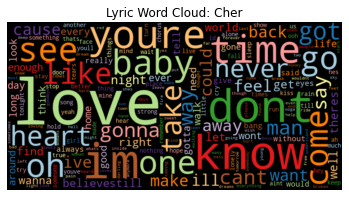

In [42]:
# Lyric cloud for Cher:

lyric_freq = count_words(lyrics_data[lyrics_data['artist']=='cher'])
wordcloud(lyric_freq['freq'], title='Lyric Word Cloud: Cher')

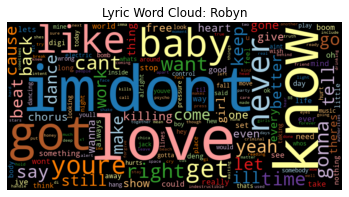

In [43]:
# Lyric cloud for Robyn:

lyric_freq = count_words(lyrics_data[lyrics_data['artist']=='robyn'])
wordcloud(lyric_freq['freq'], title='Lyric Word Cloud: Robyn')

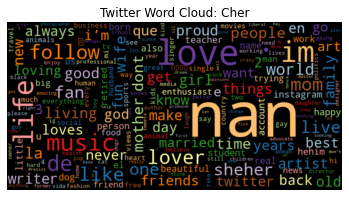

In [44]:
# Twitter cloud for Cher:

twitter_freq = count_words(twitter_data[twitter_data['artist']=='cher'])
wordcloud(twitter_freq['freq'], title='Twitter Word Cloud: Cher')

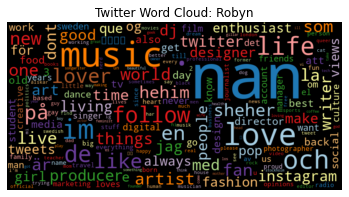

In [45]:
# Twitter cloud for Robyn:

twitter_freq = count_words(twitter_data[twitter_data['artist']=='robyn'])
wordcloud(twitter_freq['freq'], title='Twitter Word Cloud: Robyn')

# Section Complete

Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: Lyric Data: It seems like the top tokens are love and baby. It seems like they have pretty similar word clouds between the two artists. I wonder if you could argue that this is either a standard for their type of music to have lyrics cetnered around love or if it is just a coincidence with these two artists. There are very many lyrics shared between the two like: "I'm, take, know." Not to analyze the twitter data to see if followers have similiar comments. It is interesitng to compare these word clouds to the frequncy histograms from the previous assignment. 
   Twitter Data: It seems that off the bat I should ignore the top "nan" from there it seems the followers use "love, music, like, artist." It seems to me that they are describing their artist and the personal pronouns used. Two standouts for me are "instagram" and "married." It seems that instagram is not used as much for cher followers compared to Robyn, possibly could describe the younger followers of Robyn. Also married being used more in the Cher wrod cloud could suggest that the followers are older of Cher. 